# Imports

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm import tqdm

# Custom
from config import model_config
from regression import reg

# Stats
from sklearn.base import (
	BaseEstimator, TransformerMixin
)
from sklearn.compose import (
	ColumnTransformer
)
from sklearn.decomposition import (
	PCA
)
from sklearn.ensemble import (
	RandomForestClassifier
)
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression,
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score,
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer, FunctionTransformer
)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Global vars
SEED = 123
TEST_SIZE = 0.25
HEATMAP_COLORS = sns.diverging_palette(h_neg=250, h_pos=359, as_cmap=True)
SIGNIFICANCE_CUTOFF = 0.05

# Import/Preprocess Data

In [80]:
with open(Path('../data/prediction_data.pkl'), 'rb') as f:
	data = pickle.load(f)
	
X = data.get('X')
y = data.get('y')
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')

print(X.shape)

X.head()

(90, 24)


,density_visceral_fat,mass_visceral_fat,density_subcutaneous_fat,volume_intermuscular_fat,density_intermuscular_fat,density_muscle,mass_muscle,density_bone,mass_bone,bsa,...,bv5,pb_larger_10,a_diameter,pv_a,heart_volume,airway_volume,airway_ratio,ild_volume,age,gender_cl_Male
PE1_0,-0.804596,-1.006961,-0.066012,1.331630,-0.066012,-0.322773,1.007574,-1.754047,1.134155,5.199338,...,0.124882,1.843089,0.947761,1.199407,1.818949,1.208424,-0.337578,-0.519639,-0.099108,1.0
PE12_0,-0.132313,0.893337,-1.252120,1.197132,-1.003148,-0.479506,1.035795,-0.597841,1.032652,0.716498,...,0.794604,0.518666,-0.640149,1.252273,0.097809,1.439863,0.469267,0.926287,-0.382953,1.0
PE12_1,0.132313,1.353718,0.406724,0.215841,1.008759,0.855712,1.803910,-0.103421,1.345373,0.716498,...,-1.748358,0.735412,0.030429,-0.169806,0.474218,0.302507,1.594807,1.566161,-0.382953,1.0
PE14_0,1.412188,-0.675649,1.252120,-1.039624,1.354934,0.199201,0.551134,-0.169270,0.766997,-0.804596,...,0.178621,0.072902,-0.200470,0.102281,0.113720,0.600126,-0.634274,-5.199338,-1.008759,0.0
PE15_0,1.252120,-5.199338,1.691650,-1.617132,1.252120,1.252120,-0.366047,1.003148,-0.624630,-5.199338,...,0.595698,-0.975373,-1.654127,0.334016,-1.195727,-1.009554,0.077566,-0.078812,-5.199338,0.0


In [81]:
y.head()

,total_clot_burden,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,medial_rs5,superior_rs6,medial_basal_rs7,anterior_basal_rs8,...,posterior_basal_rs10,apical_ls1,posterior_ls2,anterior_ls3,superior_ls4,inferior_ls5,superior_ls6,anteromedial_basal_ls7_8,lateral_basal_ls9,posterior_basal_ls10
PE1_0,1.323152,1.115911,1.622695,1.628534,1.682629,1.645900,1.692823,1.684104,0.868466,1.145468,...,1.150860,-5.199338,-5.199338,1.006726,2.009940,-5.199338,-5.199338,0.722378,1.189252,1.003403
PE12_0,-0.114961,-0.195764,0.629894,-5.199338,0.523349,1.433511,1.275896,0.383191,-5.199338,1.620714,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
PE12_1,0.018764,0.258934,-5.199338,-5.199338,-5.199338,0.731753,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
PE14_0,-0.064683,0.075220,-5.199338,-5.199338,-5.199338,0.683778,-5.199338,-5.199338,-5.199338,1.250845,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.264394,-5.199338,-5.199338,0.853690,-5.199338
PE15_0,-0.405327,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.553623


In [82]:
print(body_features)
print(cardio_features)

['density_visceral_fat', 'mass_visceral_fat', 'density_subcutaneous_fat', 'volume_intermuscular_fat', 'density_intermuscular_fat', 'density_muscle', 'mass_muscle', 'density_bone', 'mass_bone', 'bsa']
['emphysema_volume_950hu', 'extrapulmonary_artery_volume', 'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5', 'pb_larger_10', 'a_diameter', 'pv_a', 'heart_volume', 'airway_volume', 'airway_ratio', 'ild_volume']


# OLS Regressions

We loop through each of the numerical target variables (the various clot burden measures for different locations, as well as the total clot burden), and perform a simple single-variable OLS regression. Shown below are the statistically significant results at the 95% confidence level.

In [83]:
def combine_feat_and_controls(features=None, controls=None):
	feat_set = set(features)
	if controls is None:
		control_set = set()
	else:
		control_set = set(controls)
	all_feat = list(feat_set.union(control_set))
	return all_feat

def ols_regression(Xdata, Ydata, targets, features=None, controls=None):
	
	all_features = combine_feat_and_controls(features, controls)
	X_temp = sm.add_constant(Xdata.loc[:, all_features])
		
	ols_results = list()

	for target in targets:
		y_temp = Ydata[[target]]
		
		single_model_results = list()
		for feat in features:
			regression_results = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
			results_df = pd.DataFrame({
				'coef': regression_results.params,
				'pvalue': regression_results.pvalues,
				'nobs': regression_results.nobs,
			}).stack()
			results_df.index = [(item[0].replace(feat, 'variable'), item[1]) for item in results_df.index.tolist()]
			results_df.name = (target, feat)
			single_model_results.append(results_df)

		all_model_results = pd.concat(single_model_results, axis=1).transpose()
		all_model_results.columns = ['_'.join(item) for item in all_model_results.columns.to_list()]
		all_model_results.index.names = ['y_var', 'x_var']
		ols_results.append(all_model_results)

	ols_cb = pd.concat(ols_results, axis=0)
	
	return ols_cb

def ols_identify_significant(ols_results, signif_cutoff, out_path, display=False):
	signif_cb_bodycomp = (
		ols_results.loc[ols_results.variable_pvalue <= signif_cutoff, :]
		.sort_values(by='variable_pvalue')
	)
	signif_cb_bodycomp.to_csv(out_path)
	if display:
		return (
			signif_cb_bodycomp
			.style
				.background_gradient(subset='variable_pvalue')
				.format("{:.3f}")
		)
	else:
		return None

def ols_heatmap(ols, out_path, subtitle, figsize=(9, 7)):
	fig, axs = plt.subplots(figsize=figsize)
	sns.heatmap(
		ols.loc[ols['variable_pvalue']<=SIGNIFICANCE_CUTOFF].variable_coef.unstack(level=1),
		annot=ols.loc[ols['variable_pvalue']<=SIGNIFICANCE_CUTOFF].variable_pvalue.unstack(level=1), 
		annot_kws={"fontsize":8},
		fmt = '.3f',
		center=0.0,
		cmap=HEATMAP_COLORS,
	)

	for t in axs.texts: 
		t.set_text('p=' + t.get_text())

	axs.set_ylabel('Clot Burden Measure')
	axs.set_xlabel('Body Composition Measure')
	plt.suptitle('Coefficient Heatmap: red=positive coef, blue=negative coef', fontsize=16)
	plt.title(subtitle, fontsize=14)
	plt.tight_layout()
	plt.savefig(out_path)
	plt.show()

## Body Composition

### Univariate Regressions

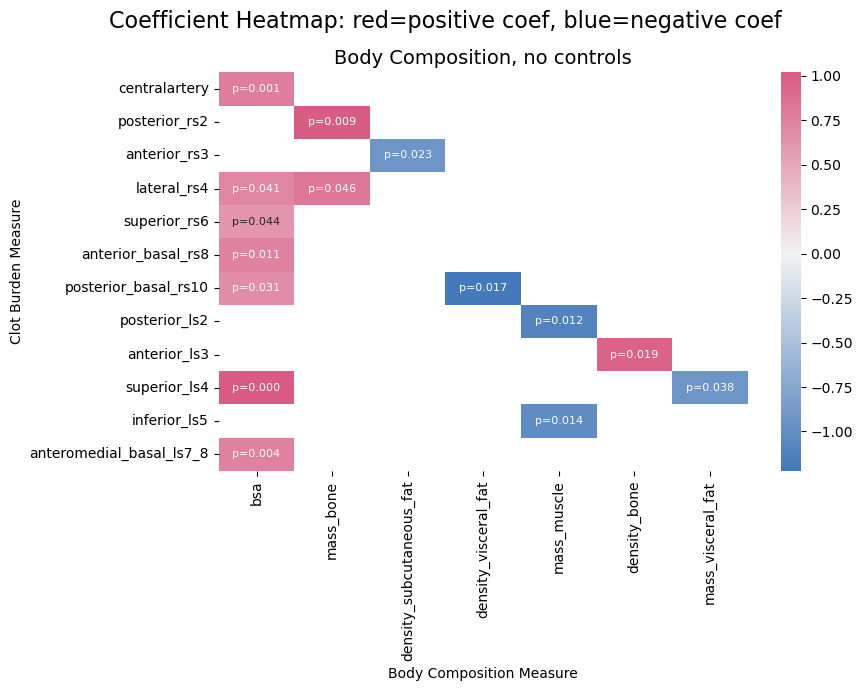

In [84]:
ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features
)

plot_subtitle = 'Body Composition, no controls'

ols_heatmap(ols, '../figures/heatmap_OLS_body_controls=None.png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_body_controls=None.csv')

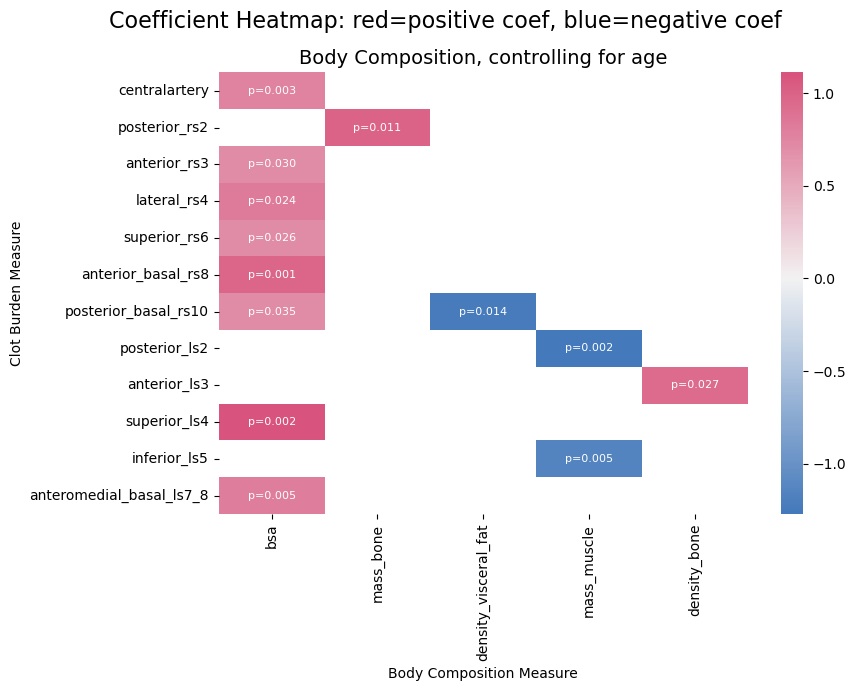

In [85]:
ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['age']
)

plot_subtitle = 'Body Composition, controlling for age'

ols_heatmap(ols, '../figures/heatmap_OLS_body_controls=[age].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_body_controls=[age].csv')

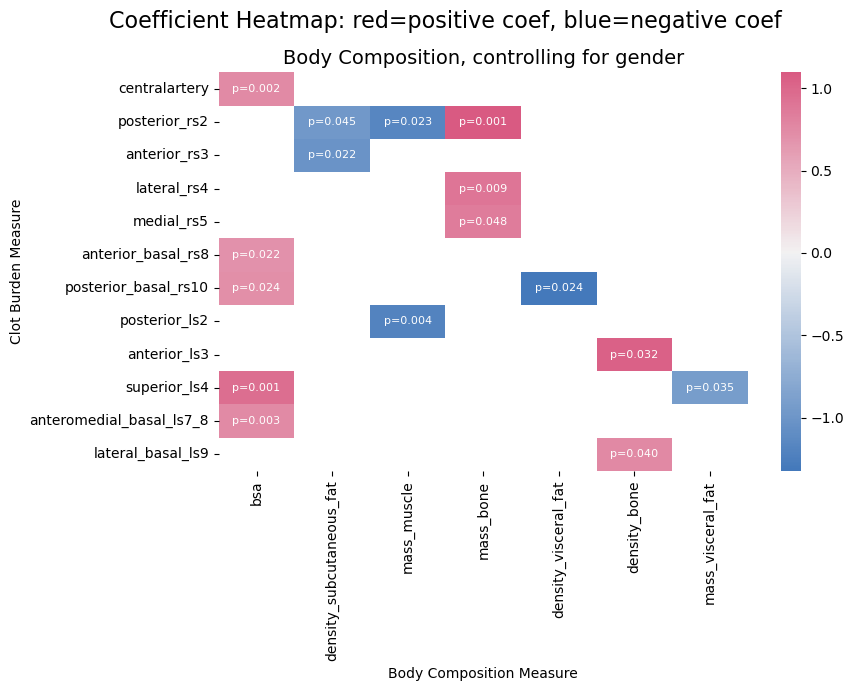

In [86]:
ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['gender_cl_Male']
)

plot_subtitle = 'Body Composition, controlling for gender'

ols_heatmap(ols, '../figures/heatmap_OLS_body_controls=[gender_cl_Male].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_body_controls=[gender_cl_Male].csv')

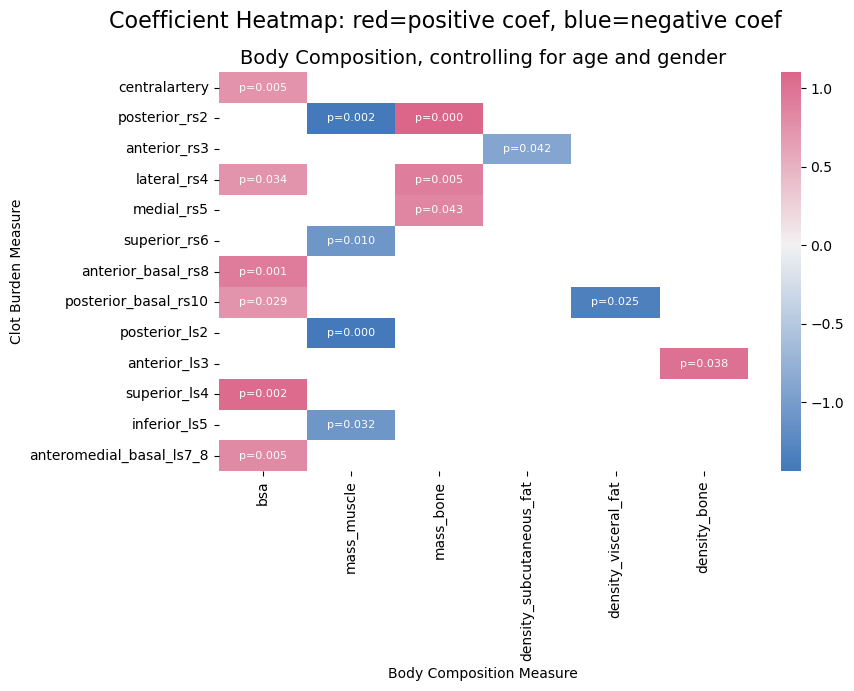

In [87]:
ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['age', 'gender_cl_Male']
)

plot_subtitle = 'Body Composition, controlling for age and gender'

ols_heatmap(ols, '../figures/heatmap_OLS_body_controls=[age, gender_cl_Male].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_body_controls=[age, gender_cl_Male].csv')

### Multivariable Regressions

#### Feature Selection

##### Recursive Feature Selection

In [88]:
rfecv_results = dict()

for target in y.columns:
	ols = LinearRegression()

	rfecv = RFECV(
		estimator=ols,
		step=1,
		scoring='neg_mean_squared_error',
		cv=10
	)

	rfecv.fit(X[body_features], y[target])
	rfecv_results[target] = list(rfecv.get_feature_names_out())

rfecv_results

{'total_clot_burden': ['density_bone'],
 'centralartery': ['density_bone', 'bsa'],
 'apical_rs1': ['mass_bone'],
 'posterior_rs2': ['mass_bone'],
 'anterior_rs3': ['density_visceral_fat',
  'mass_visceral_fat',
  'density_subcutaneous_fat',
  'density_intermuscular_fat',
  'density_muscle',
  'mass_muscle',
  'mass_bone',
  'bsa'],
 'lateral_rs4': ['bsa'],
 'medial_rs5': ['mass_bone'],
 'superior_rs6': ['density_subcutaneous_fat'],
 'medial_basal_rs7': ['density_subcutaneous_fat',
  'density_intermuscular_fat',
  'density_muscle',
  'density_bone',
  'bsa'],
 'anterior_basal_rs8': ['density_subcutaneous_fat'],
 'lateral_basal_rs9': ['mass_muscle'],
 'posterior_basal_rs10': ['mass_muscle'],
 'apical_ls1': ['density_bone'],
 'posterior_ls2': ['mass_bone'],
 'anterior_ls3': ['density_visceral_fat', 'density_bone'],
 'superior_ls4': ['mass_visceral_fat', 'volume_intermuscular_fat', 'bsa'],
 'inferior_ls5': ['mass_bone'],
 'superior_ls6': ['density_muscle'],
 'anteromedial_basal_ls7_8': ['v

In [89]:
rfecv_regressions = pd.DataFrame()

for target in y.columns:
	y_vars = rfecv_results[target]
	X_temp = X.loc[:, y_vars]
	y_temp = y.loc[:, target]
	results_temp = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': results_temp.params,
		'pval': results_temp.pvalues,
		'nobs': results_temp.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip([target for _ in range(res.shape[0])], res.index)),
		names=('y', 'X')
	)
	res.index.names
	rfecv_regressions = pd.concat((rfecv_regressions, res), axis=0)
	
rfecv_regressions

coef      pval  nobs  \
y                        X                                                     
total_clot_burden        density_bone               0.380959  0.066783  90.0   
centralartery            density_bone               0.627954  0.009646  90.0   
                         bsa                        0.765315  0.000009  90.0   
apical_rs1               mass_bone                  0.658508  0.041612  90.0   
posterior_rs2            mass_bone                  0.471800  0.154696  90.0   
anterior_rs3             density_visceral_fat       0.016107  0.982484  90.0   
                         mass_visceral_fat         -0.313314  0.579960  90.0   
                         density_subcutaneous_fat  -0.812893  0.232174  90.0   
                         density_intermuscular_fat -0.199194  0.732371  90.0   
                         density_muscle             0.921707  0.178896  90.0   
                         mass_muscle               -0.617785  0.263746  90.0   
                         mass_bone                  0.383769  0.475546  90.0   
                         bsa                        0.776320  0.056378  90.0   
lateral_rs4              bsa                        0.773124  0.000138  90.0   
medial_rs5               mass_bone                  0.593775  0.089949  90.0   
superior_rs6             density_subcutaneous_fat  -0.709306  0.011548  90.0   
medial_basal_rs7         density_subcutaneous_fat  -0.771418  0.121359  90.0   
                         density_intermuscular_fat  0.746306  0.068453  90.0   
                         density_muscle             0.703191  0.250398  90.0   
                         density_bone               0.808317  0.085517  90.0   
                         bsa                        0.749836  0.016391  90.0   
anterior_basal_rs8       density_subcutaneous_fat  -0.812593  0.007081  90.0   
lateral_basal_rs9        mass_muscle                0.499828  0.120909  90.0   
posterior_basal_rs10     mass_muscle               -0.400905  0.203090  90.0   
apical_ls1               density_bone               0.494404  0.169147  90.0   
posterior_ls2            mass_bone                  0.273035  0.473345  90.0   
anterior_ls3             density_visceral_fat      -0.412335  0.200357  90.0   
                         density_bone               0.795811  0.013775  90.0   
superior_ls4             mass_visceral_fat         -0.738193  0.123414  90.0   
                         volume_intermuscular_fat  -0.915746  0.064229  90.0   
                         bsa                        1.367583  0.007224  90.0   
inferior_ls5             mass_bone                  0.332363  0.373581  90.0   
superior_ls6             density_muscle             0.526038  0.134353  90.0   
anteromedial_basal_ls7_8 volume_intermuscular_fat  -0.808291  0.066624  90.0   
                         bsa                        1.028473  0.002838  90.0   
lateral_basal_ls9        density_visceral_fat      -0.779217  0.012604  90.0   
posterior_basal_ls10     density_visceral_fat      -0.900223  0.003434  90.0   
                         density_intermuscular_fat  0.978962  0.003387  90.0   

                                                   signif  
y                        X                                 
total_clot_burden        density_bone                      
centralartery            density_bone                  **  
                         bsa                          ***  
apical_rs1               mass_bone                      *  
posterior_rs2            mass_bone                         
anterior_rs3             density_visceral_fat              
                         mass_visceral_fat                 
                         density_subcutaneous_fat          
                         density_intermuscular_fat         
                         density_muscle                    
                         mass_muscle                       
                         mass_bone                         
               

##### Sequential Feature Selection

In [90]:
sfs_fwd_results = dict()

for target in y.columns:
	ols = LinearRegression()

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='forward',
		cv=10
	)

	sfs_fwd.fit(X[body_features], y[target])
	sfs_fwd_results[target] = sfs_fwd.get_feature_names_out()

sfs_fwd_results

{'total_clot_burden': array(['density_bone', 'mass_bone'], dtype=object),
 'centralartery': array(['volume_intermuscular_fat', 'density_bone', 'bsa'], dtype=object),
 'apical_rs1': array(['density_subcutaneous_fat', 'density_muscle', 'mass_bone'],
       dtype=object),
 'posterior_rs2': array(['density_subcutaneous_fat', 'mass_bone'], dtype=object),
 'anterior_rs3': array(['mass_visceral_fat', 'density_subcutaneous_fat', 'density_bone',
        'bsa'], dtype=object),
 'lateral_rs4': array(['mass_visceral_fat', 'density_subcutaneous_fat', 'mass_bone',
        'bsa'], dtype=object),
 'medial_rs5': array(['density_visceral_fat', 'mass_bone'], dtype=object),
 'superior_rs6': array(['density_visceral_fat', 'volume_intermuscular_fat', 'density_bone',
        'bsa'], dtype=object),
 'medial_basal_rs7': array(['volume_intermuscular_fat', 'density_intermuscular_fat',
        'density_bone', 'bsa'], dtype=object),
 'anterior_basal_rs8': array(['density_subcutaneous_fat'], dtype=object),
 'latera

In [91]:
sfs_fwd_regressions = pd.DataFrame()

for target in model_config.num_targets:
	y_vars = sfs_fwd_results[target]
	X_temp = X.loc[:, y_vars]
	y_temp = y.loc[:, target]
	results_temp = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': results_temp.params,
		'pval': results_temp.pvalues,
		'nobs': results_temp.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip([target for _ in range(res.shape[0])], res.index)),
		names=('y', 'X')
	)
	res.index.names
	sfs_fwd_regressions = pd.concat((sfs_fwd_regressions, res), axis=0)
	
sfs_fwd_regressions

coef      pval  nobs  \
y                        X                                                     
total_clot_burden        density_bone               0.302370  0.135550  90.0   
                         mass_bone                  0.337678  0.045970  90.0   
centralartery            volume_intermuscular_fat  -0.336198  0.279648  90.0   
                         density_bone               0.600488  0.013323  90.0   
                         bsa                        0.967670  0.000049  90.0   
apical_rs1               density_subcutaneous_fat  -0.869760  0.045925  90.0   
                         density_muscle             0.471117  0.307860  90.0   
                         mass_bone                  0.616101  0.076577  90.0   
posterior_rs2            density_subcutaneous_fat  -0.427322  0.204428  90.0   
                         mass_bone                  0.539542  0.108484  90.0   
anterior_rs3             mass_visceral_fat         -0.443054  0.316661  90.0   
                         density_subcutaneous_fat  -0.402754  0.429223  90.0   
                         density_bone               0.580726  0.228708  90.0   
                         bsa                        0.816037  0.022770  90.0   
lateral_rs4              mass_visceral_fat         -0.723223  0.133881  90.0   
                         density_subcutaneous_fat  -0.426380  0.300025  90.0   
                         mass_bone                  0.718032  0.032732  90.0   
                         bsa                        0.758647  0.069985  90.0   
medial_rs5               density_visceral_fat      -0.464994  0.218219  90.0   
                         mass_bone                  0.500093  0.174308  90.0   
superior_rs6             density_visceral_fat      -0.909414  0.026631  90.0   
                         volume_intermuscular_fat  -0.617960  0.214008  90.0   
                         density_bone               0.321581  0.389614  90.0   
                         bsa                        0.868642  0.009176  90.0   
medial_basal_rs7         volume_intermuscular_fat  -0.492047  0.377294  90.0   
                         density_intermuscular_fat  0.433385  0.280232  90.0   
                         density_bone               0.864679  0.008163  90.0   
                         bsa                        1.111590  0.004053  90.0   
anterior_basal_rs8       density_subcutaneous_fat  -0.812593  0.007081  90.0   
lateral_basal_rs9        mass_bone                  0.589967  0.038023  90.0   
posterior_basal_rs10     mass_muscle               -0.400905  0.203090  90.0   
apical_ls1               density_bone               0.494404  0.169147  90.0   
posterior_ls2            density_muscle             0.362976  0.468631  90.0   
anterior_ls3             density_bone               0.704525  0.028427  90.0   
superior_ls4             density_visceral_fat      -0.653685  0.200662  90.0   
                         mass_visceral_fat         -0.965454  0.073312  90.0   
                         volume_intermuscular_fat  -0.882686  0.132094  90.0   
                         density_muscle             0.431148  0.355419  90.0   
                         bsa                        1.367164  0.018143  90.0   
inferior_ls5             density_visceral_fat      -0.492926  0.228522  90.0   
                         density_bone               0.309231  0.507529  90.0   
superior_ls6             density_bone               0.609806  0.046663  90.0   
                         bsa                        0.514195  0.140130  90.0   
anteromedial_basal_ls7_8 density_visceral_fat      -0.544899  0.075069  90.0   
lateral_basal_ls9        density_visceral_fat      -0.624098  0.124004  90.0   
                         density_bone               0.359020  0.385378  90.0   
                         bsa                        0.617058  0.021448  90.0   
posterior_basal_ls10     density_visceral_fat      -0.873378  0.007209  90.0   
                         density_intermuscular_fat  0.95

## Cardiopulmonary

### Univariate Regressions

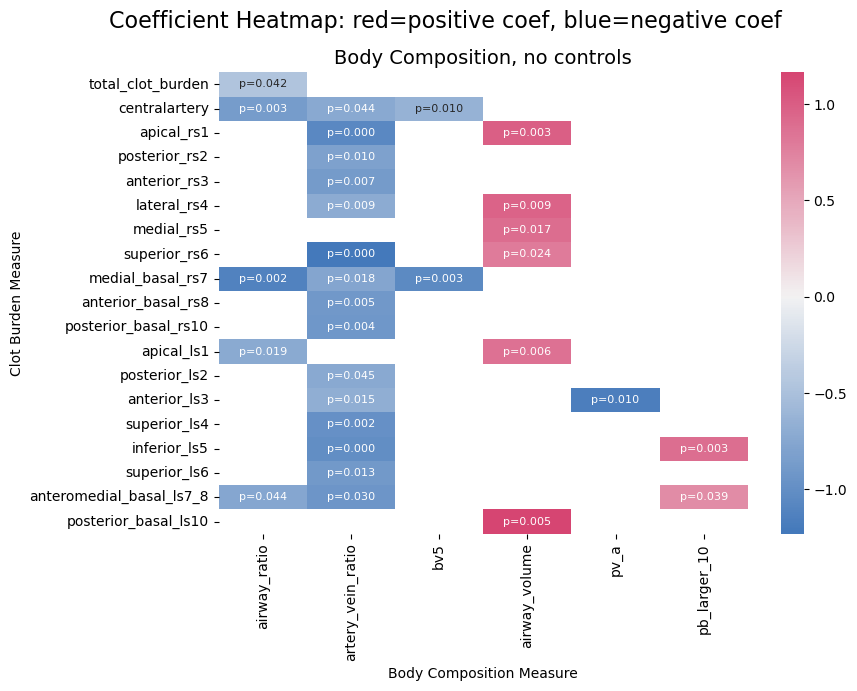

In [92]:
ols = ols_regression(
	Xdata=X,
	Ydata=y,  
	targets=y.columns,
	features=cardio_features
)

plot_subtitle = 'Body Composition, no controls'

ols_heatmap(ols, '../figures/heatmap_OLS_cardio_controls=None.png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_cardio_controls=None.csv')

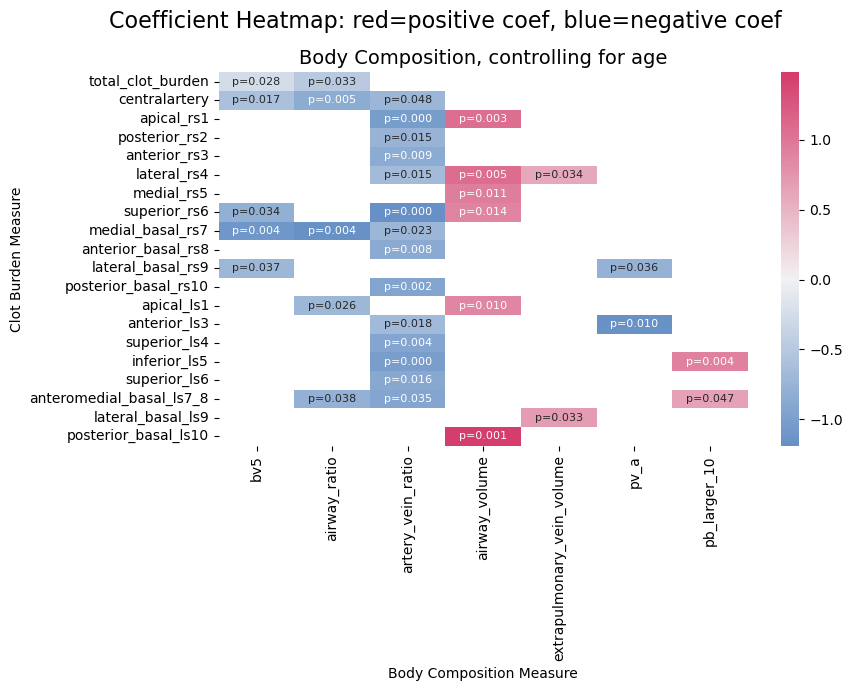

In [93]:
ols = ols_regression(
	Xdata=X,
	Ydata=y,
	targets=y.columns,
	features=cardio_features,
	controls=['age']
)

plot_subtitle = 'Body Composition, controlling for age'

ols_heatmap(ols, '../figures/heatmap_OLS_cardio_controls=[age].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_cardio_controls=[age].csv')

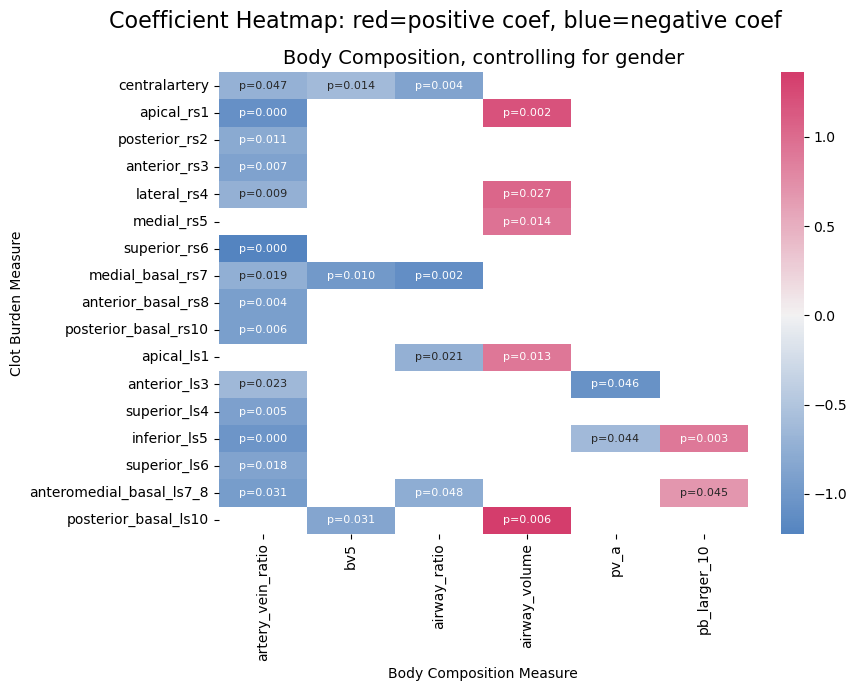

In [94]:
ols = ols_regression(
	Xdata=X,
	Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['gender_cl_Male']
)

plot_subtitle = 'Body Composition, controlling for gender'

ols_heatmap(ols, '../figures/heatmap_OLS_cardio_controls=[gender_cl_Male].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_cardio_controls=[gender_cl_Male].csv')

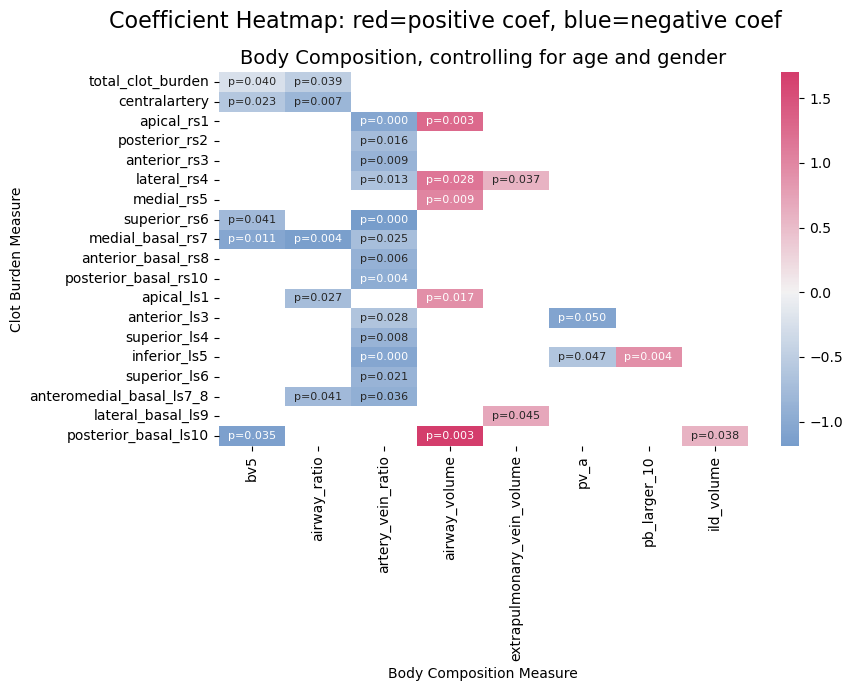

In [95]:
ols = ols_regression(
	Xdata=X,
	Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['age', 'gender_cl_Male']
)

plot_subtitle = 'Body Composition, controlling for age and gender'

ols_heatmap(ols, '../figures/heatmap_OLS_cardio_controls=[age, gender_cl_Male].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_cardio_controls=[age, gender_cl_Male].csv')

### Multivariable Regressions

#### Feature Selection

##### Recursive Feature Selection

##### Sequential Feature Selection